In [1]:
from google.colab import files
uploaded = files.upload()  # choose assignment2-rag.zip

import zipfile, io, os, shutil
zip_name = next(iter(uploaded))
extract_dir = "/content"
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as z:
    z.extractall(extract_dir)

# If it unzips with a top-level folder name, fix path:
!ls -1 /content
%cd /content/assignment2-rag

Saving assignment2-rag.zip to assignment2-rag.zip
assignment2-rag
assignment2-rag.zip
sample_data
/content/assignment2-rag


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%cd /content/assignment2-rag

from datasets import load_dataset
import json, os

os.makedirs("data/evaluation", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

qa = load_dataset("rag-datasets/rag-mini-wikipedia", "question-answer", split="test")
corpus = load_dataset("rag-datasets/rag-mini-wikipedia", "text-corpus", split="passages")

with open("data/evaluation/gold.jsonl", "w") as f:
    for r in qa:
        f.write(json.dumps({"id": int(r["id"]), "question": r["question"], "answer": r["answer"]})+"\n")

with open("data/processed/corpus.jsonl", "w") as f:
    for r in corpus:
        f.write(json.dumps({"id": str(r["id"]), "title": "", "text": r["passage"]})+"\n")

print("✅ Overwrote gold.jsonl and corpus.jsonl")

/content/assignment2-rag


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/719 [00:00<?, ?B/s]

data/test.parquet/part.0.parquet:   0%|          | 0.00/54.4k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/918 [00:00<?, ? examples/s]

data/passages.parquet/part.0.parquet:   0%|          | 0.00/797k [00:00<?, ?B/s]

Generating passages split:   0%|          | 0/3200 [00:00<?, ? examples/s]

✅ Overwrote gold.jsonl and corpus.jsonl


#### Inspect Schema

In [20]:
print("\n--- QA Features ---")
print(qa.features)

print("\n--- Corpus Features ---")
print(corpus.features)


--- QA Features ---
{'question': Value('string'), 'answer': Value('string'), 'id': Value('int64')}

--- Corpus Features ---
{'passage': Value('string'), 'id': Value('int64')}


#### Show Sample Entries

In [21]:
print("\n--- Sample QA ---")
print(qa[0])

print("\n--- Sample Corpus ---")
print(corpus[0])


--- Sample QA ---
{'question': 'Was Abraham Lincoln the sixteenth President of the United States?', 'answer': 'yes', 'id': 0}

--- Sample Corpus ---
{'passage': 'Uruguay (official full name in  ; pron.  , Eastern Republic of  Uruguay) is a country located in the southeastern part of South America.  It is home to 3.3 million people, of which 1.7 million live in the capital Montevideo and its metropolitan area.', 'id': 0}


#### Basic Stats

In [22]:
qa_df = pd.DataFrame(qa)
corpus_df = pd.DataFrame(corpus)

print("\nQA columns:", qa_df.columns.tolist())
print("Corpus columns:", corpus_df.columns.tolist())

qa_df["q_len"] = qa_df["question"].str.len()
qa_df["a_len"] = qa_df["answer"].str.len()
corpus_df["passage_len"] = corpus_df["passage"].str.len()

print("\n--- QA Stats ---")
print("Avg question length:", qa_df['q_len'].mean())
print("Avg answer length:", qa_df['a_len'].mean())

print("\n--- Corpus Stats ---")
print("Avg passage length:", corpus_df['passage_len'].mean())
print("Min passage length:", corpus_df['passage_len'].min())
print("Max passage length:", corpus_df['passage_len'].max())


QA columns: ['question', 'answer', 'id']
Corpus columns: ['passage', 'id']

--- QA Stats ---
Avg question length: 53.09041394335512
Avg answer length: 19.18300653594771

--- Corpus Stats ---
Avg passage length: 389.848125
Min passage length: 1
Max passage length: 2515


#### Data quality checks

In [23]:
print("\n--- Data Quality Checks ---")
print("Duplicate QA IDs:", qa_df['id'].duplicated().sum())
print("Duplicate Corpus IDs:", corpus_df['id'].duplicated().sum())


--- Data Quality Checks ---
Duplicate QA IDs: 0
Duplicate Corpus IDs: 0


#### Check for missing values

In [24]:
print("Missing in QA:", qa_df.isna().sum().to_dict())
print("Missing in Corpus:", corpus_df.isna().sum().to_dict())

Missing in QA: {'question': 0, 'answer': 0, 'id': 0, 'q_len': 0, 'a_len': 0}
Missing in Corpus: {'passage': 0, 'id': 0, 'passage_len': 0}


#### Potential edge-cases


In [25]:
print("\nShortest 3 passages:")
display(corpus_df.nsmallest(3, "passage_len")[["id", "passage_len", "passage"]])
print("\nLongest 3 passages:")
display(corpus_df.nlargest(3, "passage_len")[["id", "passage_len", "passage"]])


Shortest 3 passages:


,id,passage_len,passage
895,896,1,|
759,760,2,;
897,898,2,|}



Longest 3 passages:


,id,passage_len,passage
2095,2096,2515,"As Ford approached his ninetieth year, he bega..."
2933,2934,2493,Roosevelt was the first American president to ...
1777,1778,2298,"After the Mexican-American war ended in 1848, ..."


### Visualizations

#### 1) Length histograms

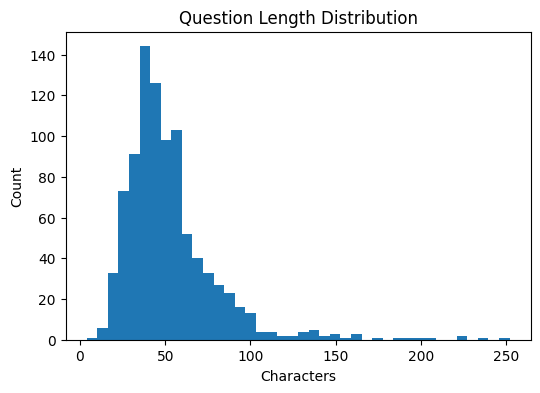

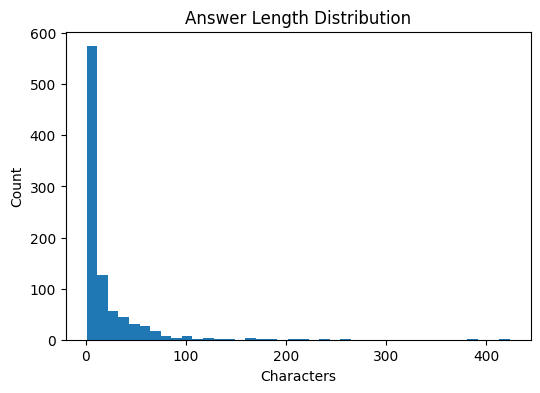

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [26]:
plt.figure(figsize=(6,4))
plt.hist(qa_df["q_len"], bins=40)
plt.title("Question Length Distribution")
plt.xlabel("Characters"); plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(qa_df["a_len"], bins=40)
plt.title("Answer Length Distribution")
plt.xlabel("Characters"); plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))

#### 2) Scatter: question vs answer length

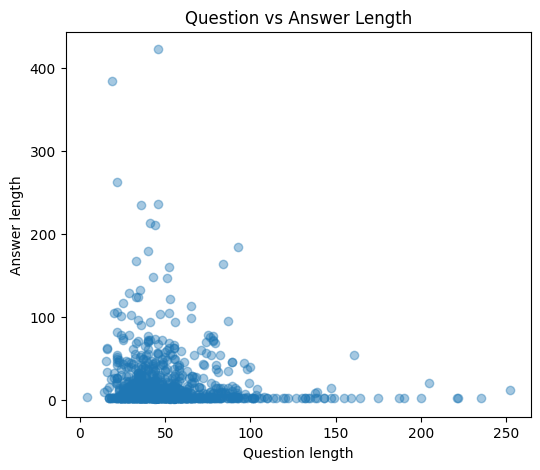

In [28]:
plt.figure(figsize=(6,5))
sample = qa_df.sample(min(1000, len(qa_df)), random_state=42)  # sample for readability
plt.scatter(sample["q_len"], sample["a_len"], alpha=0.4)
plt.title("Question vs Answer Length")
plt.xlabel("Question length"); plt.ylabel("Answer length")
plt.show()

#### 3) Percentiles for passages

In [27]:
pct = np.percentile(corpus_df["passage_len"], [50, 75, 90, 95, 99])
print("\nPassage length percentiles (chars):")
for p, v in zip([50,75,90,95,99], pct):
    print(f"  p{p}: {int(v)}")


Passage length percentiles (chars):
  p50: 299
  p75: 574
  p90: 857
  p95: 1061
  p99: 1489
